step 1: choosing a dataset - Life Expectancy (WHO)

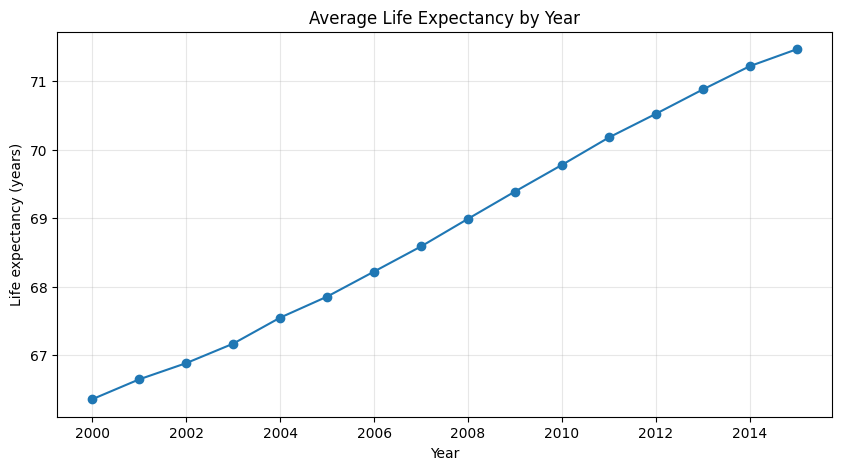

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv("Life-Expectancy-Data-Updated.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Make sure the key columns are numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Life_expectancy"] = pd.to_numeric(df["Life_expectancy"], errors="coerce")

# Keep only rows where we can plot
df_plot = df.dropna(subset=["Year", "Life_expectancy"]).copy()
df_plot["Year"] = df_plot["Year"].astype(int)

df_plot[["Year", "Life_expectancy"]].describe()

yearly = (
    df_plot.groupby("Year", as_index=False)["Life_expectancy"]
    .mean()
    .sort_values("Year")
)

plt.figure(figsize=(10, 5))
plt.plot(yearly["Year"], yearly["Life_expectancy"], marker="o")
plt.title("Average Life Expectancy by Year")
plt.xlabel("Year")
plt.ylabel("Life expectancy (years)")
plt.grid(True, alpha=0.3)
plt.show()





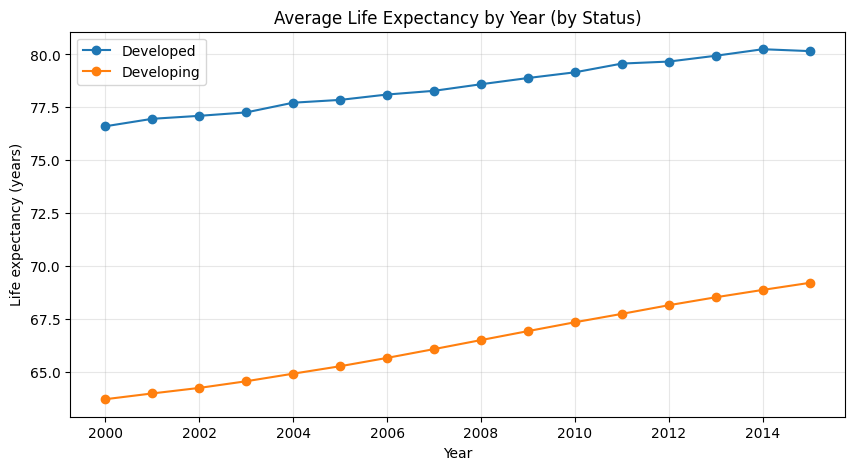

In [6]:

# 2. CREATE THE 'STATUS' COLUMN
# The new data has 1s and 0s. We map them back to "Developed" or "Developing"
# so your plotting logic has a label to use.
df['Status'] = df['Economy_status_Developed'].apply(lambda x: 'Developed' if x == 1 else 'Developing')

# 3. YOUR ORIGINAL LOGIC (Updated with correct column names)
# Note: The CSV uses "Life_expectancy" (with underscore), not "Life expectancy"
yearly_status = (
    df.groupby(["Year", "Status"])["Life_expectancy"]
    .mean()
    .reset_index()
    .sort_values("Year")
)

plt.figure(figsize=(10, 5))

# Loop through the groups to plot lines
for status, g in yearly_status.groupby("Status"):
    plt.plot(g["Year"], g["Life_expectancy"], marker="o", label=status)

plt.title("Average Life Expectancy by Year (by Status)")
plt.xlabel("Year")
plt.ylabel("Life expectancy (years)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

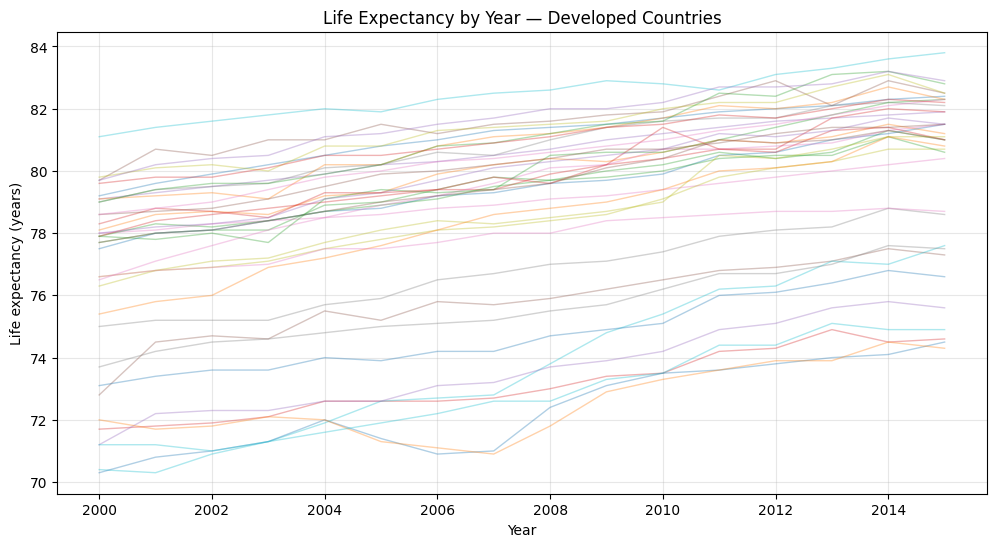

In [5]:
dev = df[df["Status"].str.strip().eq("Developed")].copy()

# Average within (Country, Year) in case duplicates exist
dev_yearly = (
    dev.groupby(["Country", "Year"], as_index=False)["Life_expectancy"]
    .mean()
    .sort_values(["Country", "Year"])
)

developed_countries = sorted(dev_yearly["Country"].unique())
len(developed_countries), developed_countries[:10]

plt.figure(figsize=(12, 6))

for country, g in dev_yearly.groupby("Country"):
    plt.plot(g["Year"], g["Life_expectancy"], alpha=0.35, linewidth=1)

plt.title("Life Expectancy by Year — Developed Countries")
plt.xlabel("Year")
plt.ylabel("Life expectancy (years)")
plt.grid(True, alpha=0.3)
plt.show()


###### vaccination and life span by year

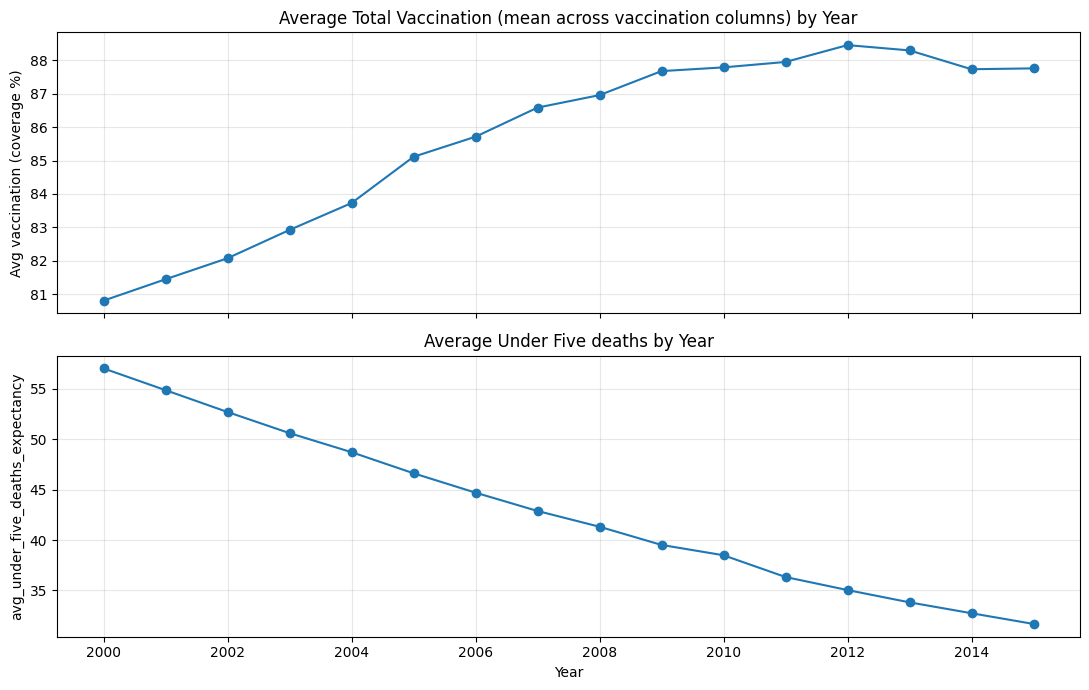

In [10]:
# Auto-detect vaccination columns (edit keywords if you want to include/exclude more)
vacc_keywords = ["hepatitis", "polio", "diphtheria", "immunization", "vacc"]

vacc_cols = [
    c for c in df.columns
    if any(k in c.lower() for k in vacc_keywords)
]

for c in vacc_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["avg_vaccination"] = df[vacc_cols].mean(axis=1, skipna=True)

yearly = (
    df.dropna(subset=["Year"])
      .groupby("Year", as_index=False)
      .agg(
          avg_under_five_deaths_expectancy=("Under_five_deaths", "mean"),
          avg_total_vaccination=("avg_vaccination", "mean"),
      )
      .sort_values("Year")
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 7), sharex=True)

# Plot 1: vaccination
axes[0].plot(yearly["Year"], yearly["avg_total_vaccination"], marker="o")
axes[0].set_title("Average Total Vaccination (mean across vaccination columns) by Year")
axes[0].set_ylabel("Avg vaccination (coverage %)")
axes[0].grid(True, alpha=0.3)

# Plot 2: life expectancy
axes[1].plot(yearly["Year"], yearly["avg_under_five_deaths_expectancy"], marker="o")
axes[1].set_title("Average Under Five deaths by Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("avg_under_five_deaths_expectancy")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



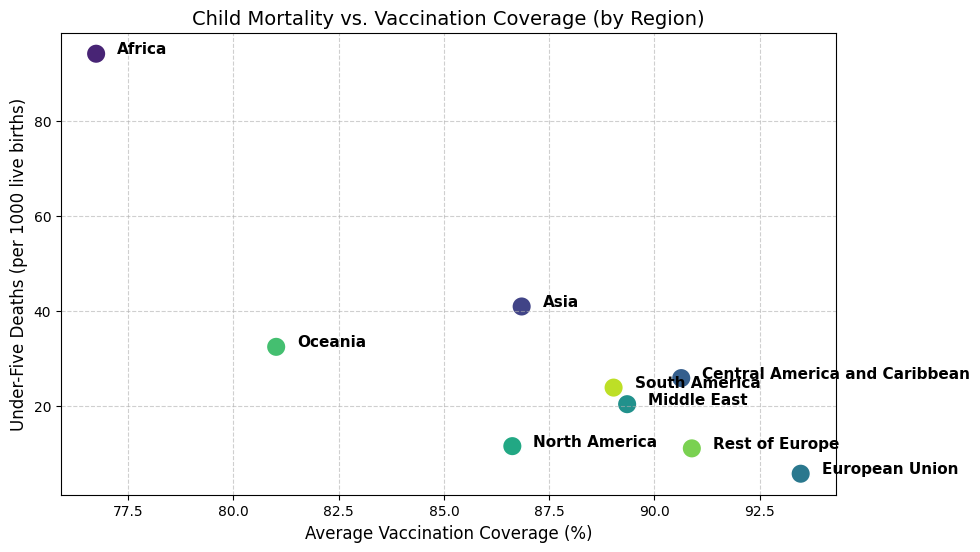

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Pre-process: Calculate Average Vaccination per Row
# Identify vaccination columns automatically
vacc_keywords = ["hepatitis", "polio", "diphtheria", "immunization", "vacc"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["avg_vaccination"] = df[vacc_cols].mean(axis=1, skipna=True)

# 3. Aggregate by Region
region_stats = (
    df.groupby("Region")
    .agg(
        avg_vaccination=("avg_vaccination", "mean"),
        avg_child_mortality=("Under_five_deaths", "mean")
    )
    .reset_index()
)

# 4. Plot: Vaccination vs Child Mortality
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=region_stats, 
    x="avg_vaccination", 
    y="avg_child_mortality", 
    s=200,                # Marker size
    hue="Region",         # Color by Region
    palette="viridis",
    legend=False          # Turn off legend if we label points directly
)

# 5. Add Labels to Points
for i in range(region_stats.shape[0]):
    plt.text(
        region_stats.avg_vaccination[i] + 0.5,  # Offset X slightly
        region_stats.avg_child_mortality[i],    # Y position
        region_stats.Region[i], 
        fontsize=11, 
        fontweight='bold'
    )

plt.title("Child Mortality vs. Vaccination Coverage (by Region)", fontsize=14)
plt.xlabel("Average Vaccination Coverage (%)", fontsize=12)
plt.ylabel("Under-Five Deaths (per 1000 live births)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [14]:
df.loc[df["Region"] == "Asia"]

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy,avg_vaccination
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4,63.666667
18,Japan,Asia,2005,2.8,3.7,68.7680,7.98,83,84,22.6,...,0.17,33099,127.77,1.7,1.5,11.2,1,0,81.9,92.000000
21,Philippines,Asia,2001,28.2,36.9,214.2685,4.53,45,19,22.3,...,0.01,1847,79.67,1.0,9.7,7.7,0,1,68.8,66.666667
26,Kazakhstan,Asia,2006,25.6,29.0,270.9885,6.76,99,99,25.8,...,0.08,7838,15.31,2.4,2.5,11.7,0,1,66.2,99.000000
30,Bhutan,Asia,2005,44.7,57.5,253.2655,0.73,95,76,22.8,...,0.19,1489,0.65,17.8,18.6,2.3,0,1,65.3,95.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,Brunei Darussalam,Asia,2009,7.8,9.6,91.9455,0.24,96,99,26.3,...,0.10,32992,0.38,6.0,5.5,8.7,0,1,74.6,98.000000
2853,Lao PDR,Asia,2000,76.5,107.2,274.4510,5.19,48,65,21.1,...,0.10,936,5.32,1.5,1.5,3.9,0,1,58.8,52.000000
2856,Japan,Asia,2014,2.1,2.8,55.5820,8.40,83,94,22.7,...,0.17,34387,127.28,2.0,1.7,12.5,1,0,83.6,92.666667
2860,Mongolia,Asia,2009,23.9,28.6,235.2330,6.56,97,97,25.3,...,0.02,2515,2.67,2.2,2.3,9.1,0,1,66.9,96.000000


C:\Users\Shir\AppData\Local\Temp\ipykernel_95832\2919103358.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\Shir\AppData\Local\Temp\ipykernel_95832\2919103358.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


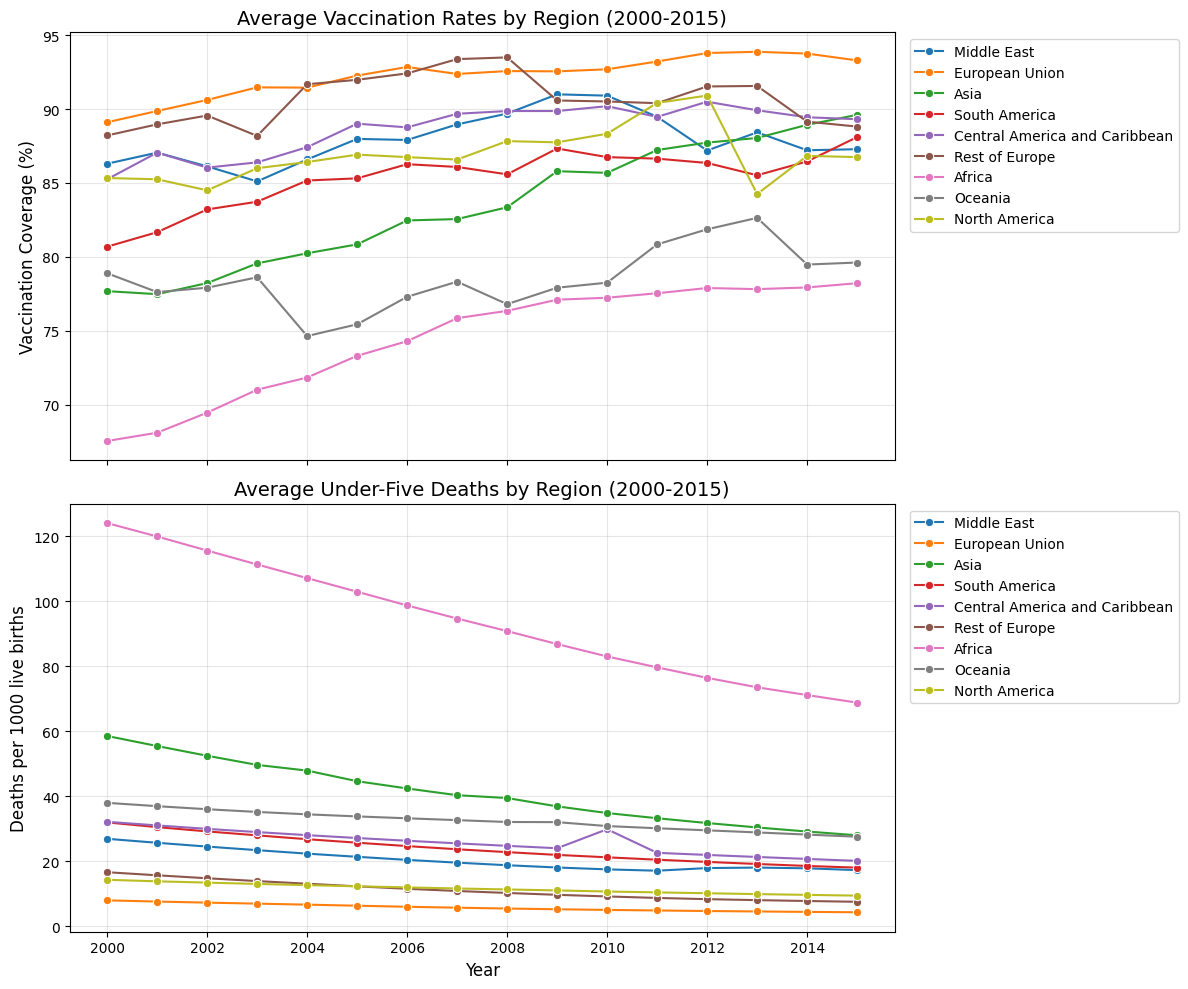

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Prepare Vaccination Data
# Identify vaccination columns (Polio, Hepatitis_B, Diphtheria)
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in ["polio", "hepatitis", "diphtheria", "measles"])]

# Calculate the average vaccination rate for each row (Country/Year)
df['avg_vaccination'] = df[vacc_cols].mean(axis=1)

# 3. Create Plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Plot 1: Vaccination Rate per Region over Years ---
sns.lineplot(
    data=df, 
    x="Year", 
    y="avg_vaccination", 
    hue="Region", 
    ax=axes[0],
    marker="o",
    ci=None  # Remove confidence interval shading for cleaner lines
)
axes[0].set_title("Average Vaccination Rates by Region (2000-2015)", fontsize=14)
axes[0].set_ylabel("Vaccination Coverage (%)", fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# --- Plot 2: Child Mortality per Region over Years ---
sns.lineplot(
    data=df, 
    x="Year", 
    y="Under_five_deaths", 
    hue="Region", 
    ax=axes[1],
    marker="o",
    ci=None
)
axes[1].set_title("Average Under-Five Deaths by Region (2000-2015)", fontsize=14)
axes[1].set_ylabel("Deaths per 1000 live births", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

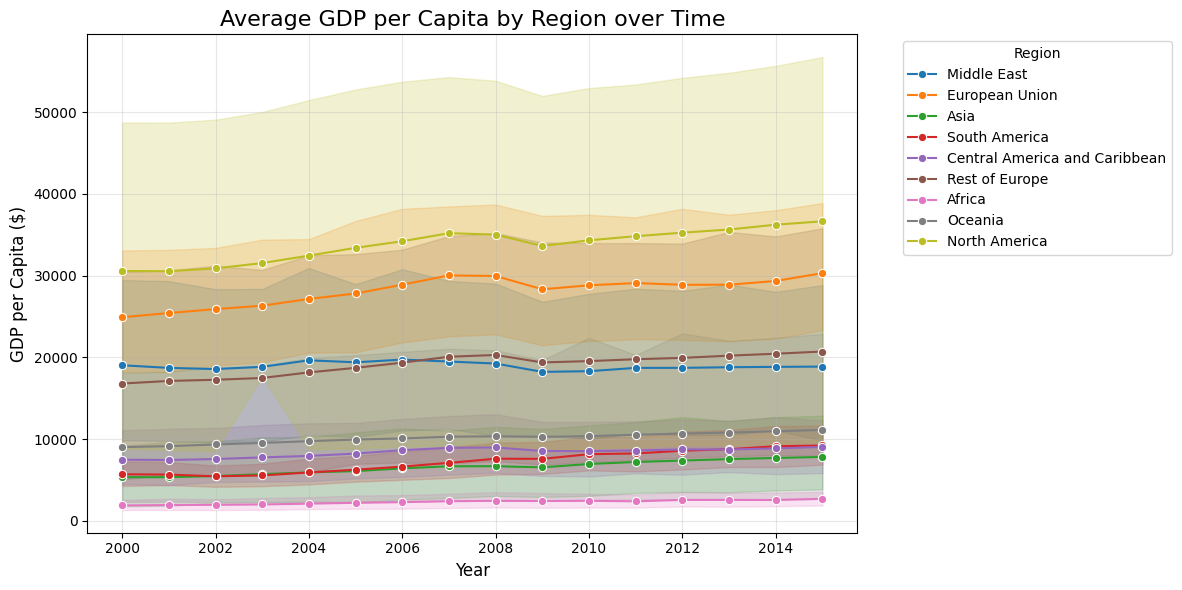

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Create the Plot
plt.figure(figsize=(12, 6))

# sns.lineplot automatically calculates the average GDP for all countries in a region for each year
sns.lineplot(
    data=df, 
    x='Year', 
    y='GDP_per_capita', 
    hue='Region', 
    marker='o'
)

# 3. Formatting
plt.title('Average GDP per Capita by Region over Time', fontsize=16)
plt.ylabel('GDP per Capita ($)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Correlation Coefficient: -0.4697


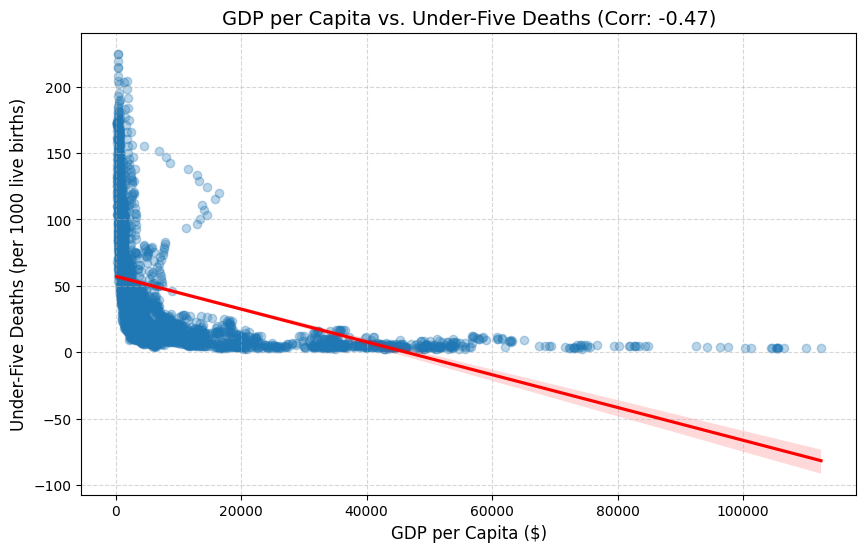

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Calculate the specific correlation number
# The result will be between -1 (perfect negative) and 1 (perfect positive)
correlation = df['Under_five_deaths'].corr(df['GDP_per_capita'])
print(f"Correlation Coefficient: {correlation:.4f}")

# 3. Visualizing the Correlation
plt.figure(figsize=(10, 6))

# regplot draws the scatter plot AND fits a linear regression line (red)
sns.regplot(
    data=df, 
    x='GDP_per_capita', 
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.3}, # Makes points transparent to see density
    line_kws={'color': 'red'}   # The regression line color
)

plt.title(f'GDP per Capita vs. Under-Five Deaths (Corr: {correlation:.2f})', fontsize=14)
plt.xlabel('GDP per Capita ($)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Log GDP vs Vaccination):
Status             
Developed   log_GDP   -0.332358
Developing  log_GDP    0.536635
Name: avg_vaccination, dtype: float64


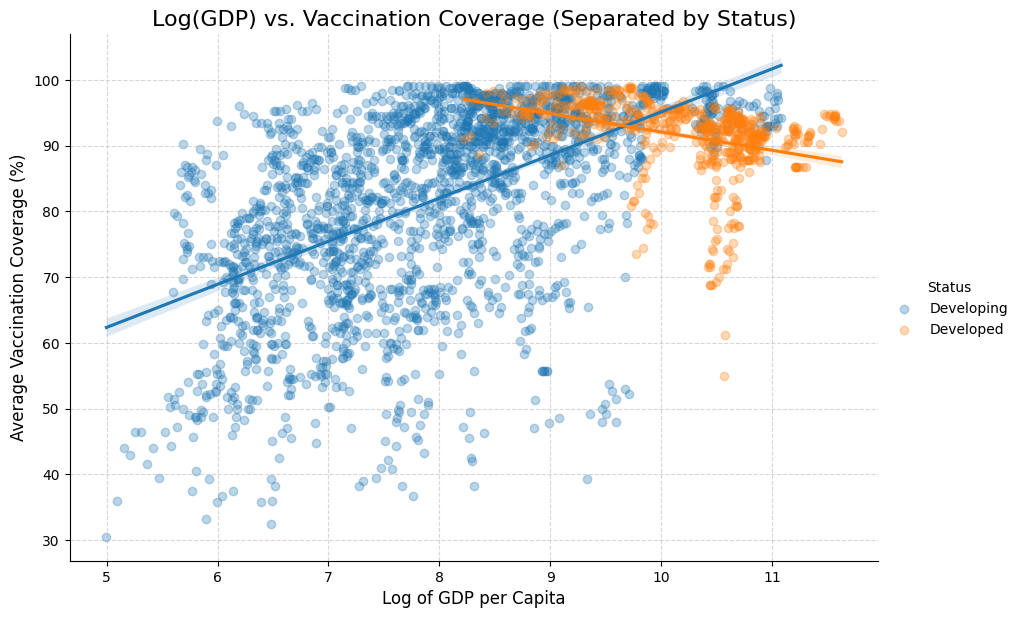

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Prepare Data
# Create 'Status' column (Developed/Developing)
df['Status'] = df['Economy_status_Developed'].apply(lambda x: 'Developed' if x == 1 else 'Developing')

# Calculate Average Vaccination
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in ["hepatitis", "polio", "diphtheria", "measles"])]
df['avg_vaccination'] = df[vacc_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# Calculate Log GDP (for better visualization)
df['log_GDP'] = np.log(df['GDP_per_capita'])

# 3. Calculate Correlations for each group
stats = df.groupby('Status')[['log_GDP', 'avg_vaccination']].corr().iloc[0::2, -1]
print("Correlation (Log GDP vs Vaccination):")
print(stats)

# 4. Plot
# lmplot draws scatter plots with regression lines for each 'hue' category
sns.lmplot(
    data=df, 
    x='log_GDP', 
    y='avg_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('Log(GDP) vs. Vaccination Coverage (Separated by Status)', fontsize=16)
plt.xlabel('Log of GDP per Capita', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developed Countries): 0.1011


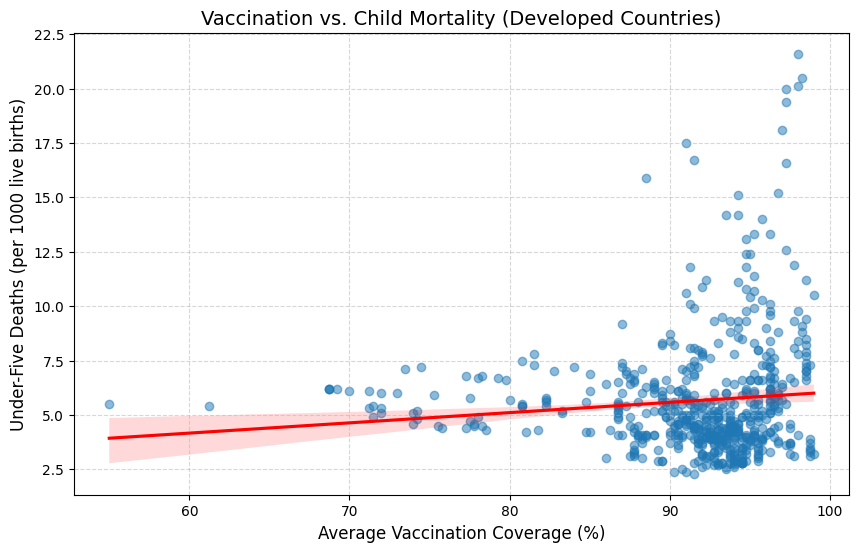

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developed_df = df[df['Economy_status_Developed'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developed_df[c] = pd.to_numeric(developed_df[c], errors='coerce')

developed_df['avg_vaccination'] = developed_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developed_df['avg_vaccination'].corr(developed_df['Under_five_deaths'])
print(f"Correlation (Developed Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developed_df,
    x='avg_vaccination',
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Child Mortality (Developed Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developing Countries): -0.7086


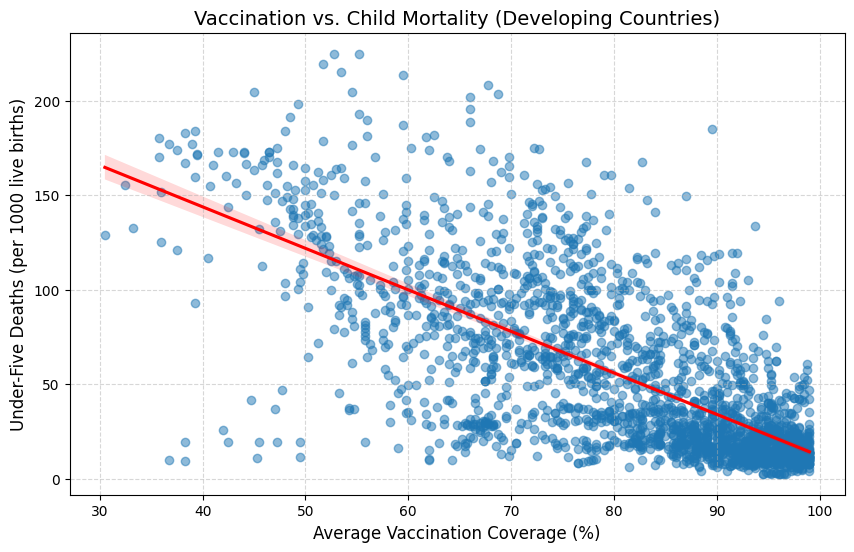

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developing_df = df[df['Economy_status_Developing'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developing_df[c] = pd.to_numeric(developing_df[c], errors='coerce')

developing_df['avg_vaccination'] = developing_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developing_df['avg_vaccination'].corr(developing_df['Under_five_deaths'])
print(f"Correlation (Developing Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developing_df,
    x='avg_vaccination',
    y='Under_five_deaths',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Child Mortality (Developing Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Under-Five Deaths (per 1000 live births)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developed Countries): -0.2905


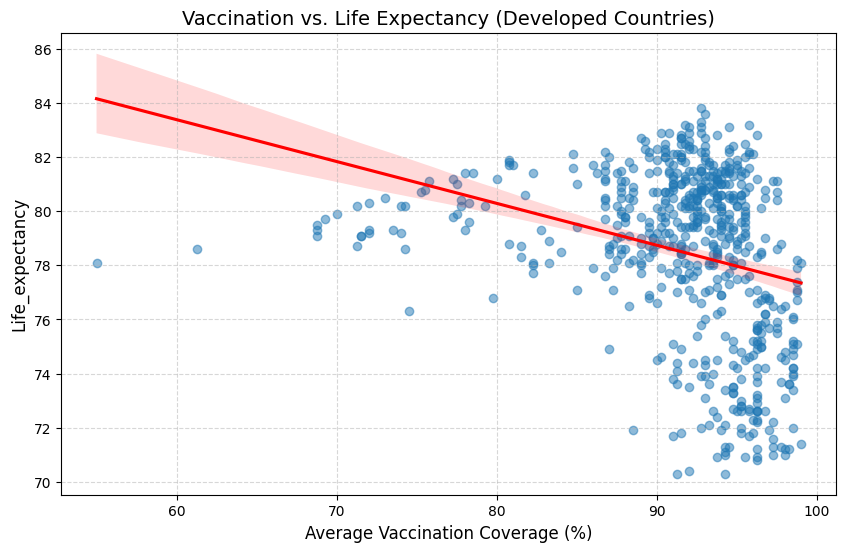

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developed_df = df[df['Economy_status_Developed'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developed_df[c] = pd.to_numeric(developed_df[c], errors='coerce')

developed_df['avg_vaccination'] = developed_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developed_df['avg_vaccination'].corr(developed_df['Life_expectancy'])
print(f"Correlation (Developed Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developed_df,
    x='avg_vaccination',
    y='Life_expectancy',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Life Expectancy (Developed Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel("Life_expectancy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (Developing Countries): 0.6258


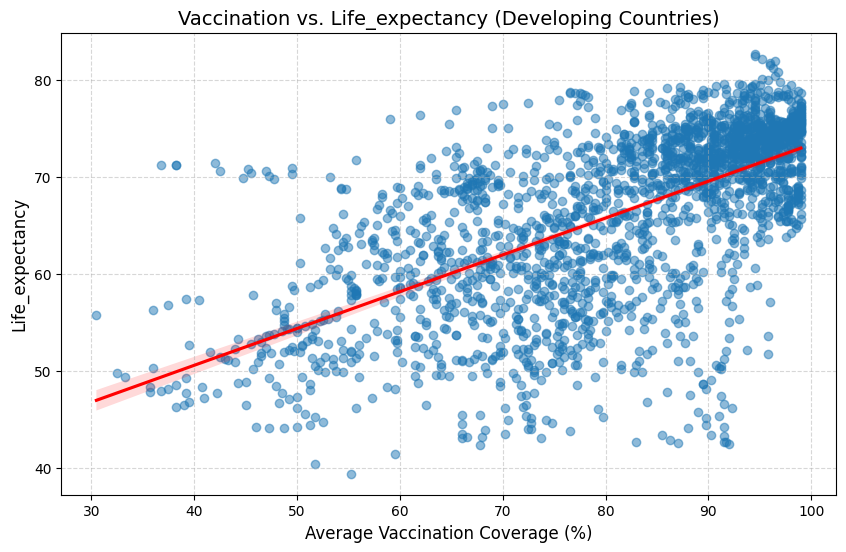

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 2. Filter for Developed Countries
# The column 'Economy_status_Developed' uses 1 for Developed
developing_df = df[df['Economy_status_Developing'] == 1].copy()

# 3. Calculate Average Vaccination
vacc_keywords = ["hepatitis", "polio", "diphtheria", "measles"]
vacc_cols = [c for c in df.columns if any(k in c.lower() for k in vacc_keywords)]

# Ensure numeric and calculate row-wise average
for c in vacc_cols:
    developing_df[c] = pd.to_numeric(developing_df[c], errors='coerce')

developing_df['avg_vaccination'] = developing_df[vacc_cols].mean(axis=1)

# 4. Calculate Correlation
correlation = developing_df['avg_vaccination'].corr(developing_df['Life_expectancy'])
print(f"Correlation (Developing Countries): {correlation:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))

sns.regplot(
    data=developing_df,
    x='avg_vaccination',
    y='Life_expectancy',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)

plt.title(f'Vaccination vs. Life_expectancy (Developing Countries)', fontsize=14)
plt.xlabel('Average Vaccination Coverage (%)', fontsize=12)
plt.ylabel('Life_expectancy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [15]:
import pandas as pd

# 1. Load your datasets
df_hdi = pd.read_csv("hdr_general.csv", encoding='latin1')
# Clean column names
df_hdi.columns = df_hdi.columns.str.strip()

# Make sure the key columns are numeric
df_hdi["year"] = pd.to_numeric(df_hdi["year"], errors="coerce")
df_hdi["hdi"] = pd.to_numeric(df_hdi["hdi"], errors="coerce")

# Keep only rows where we can plot
df_hdi_plot = df_hdi.dropna(subset=["year", "hdi"]).copy()
df_hdi_plot["year"] = df_hdi_plot["year"].astype(int)

df_hdi_plot = df_hdi_plot[['country', 'year', 'hdi']]

# 2. Perform the Join
# 'how' options:
#   'inner': Only keep rows that exist in BOTH files (intersection).
#   'left' : Keep everything in df_main, add data from df_other where it matches.
combined_df = pd.merge(
    df, 
    df_hdi_plot, 
    left_on=['Country', 'Year'], 
    right_on=['country', 'year'],
    how='inner'
)

# 3. Check the result
print(combined_df.head())
print(len(combined_df))
print(len(df))

      Country                         Region  Year  Infant_deaths  \
0       Spain                 European Union  2015            2.7   
1       India                           Asia  2007           51.5   
2      Guyana                  South America  2006           32.8   
3      Israel                    Middle East  2012            3.4   
4  Costa Rica  Central America and Caribbean  2006            9.8   

   Under_five_deaths  Adult_mortality  Alcohol_consumption  Hepatitis_B  \
0                3.3          57.9025                10.35           97   
1               67.9         201.0765                 1.57           60   
2               40.5         222.1965                 5.68           93   
3                4.3          57.9510                 2.89           97   
4               11.2          95.2200                 4.19           88   

   Measles   BMI  ...  Schooling  Economy_status_Developed  \
0       94  26.0  ...        9.7                         1   
1       35

Correlation (HDI vs Vaccination):
Status         
Developed   hdi   -0.203720
Developing  hdi    0.667923
Name: avg_vaccination, dtype: float64


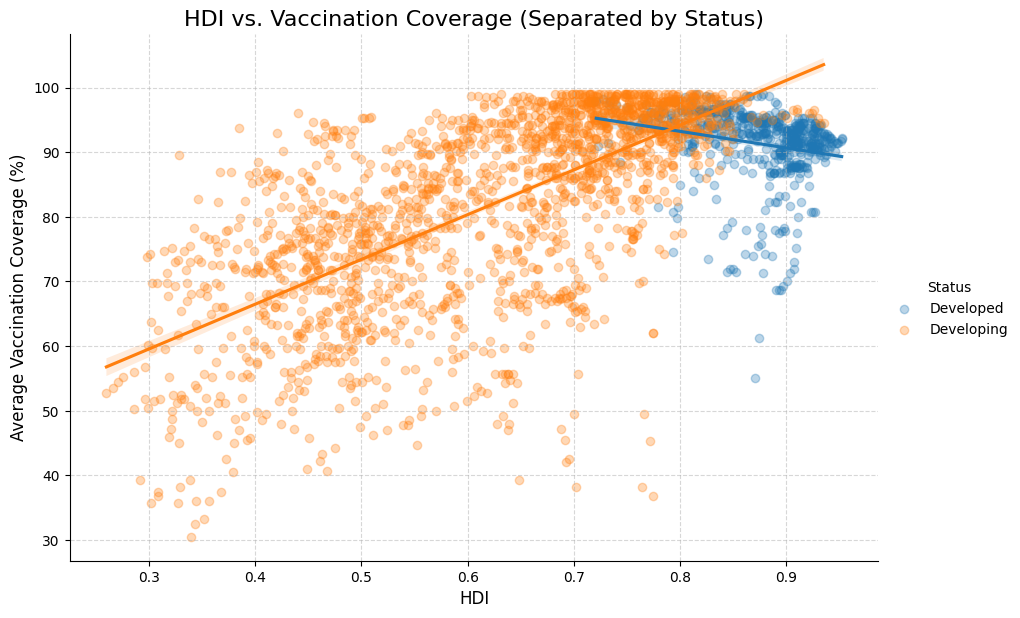

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 3. Calculate Correlations for each group
stats = combined_df.groupby('Status')[['hdi', 'avg_vaccination']].corr().iloc[0::2, -1]
print("Correlation (HDI vs Vaccination):")
print(stats)

# 4. Plot
# lmplot draws scatter plots with regression lines for each 'hue' category
sns.lmplot(
    data=combined_df, 
    x='hdi', 
    y='avg_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('HDI vs. Vaccination Coverage (Separated by Status)', fontsize=16)
plt.xlabel('HDI', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [17]:
stats = combined_df.loc[combined_df["Status"] == "Developed"].groupby('Country')[['hdi', 'avg_vaccination']].corr().iloc[0::2, -1]
print("Correlation (HDI vs Vaccination):")
print(stats)

Correlation (HDI vs Vaccination):
Country            
Australia       hdi    0.477605
Austria         hdi    0.940418
Belgium         hdi    0.934890
Bulgaria        hdi    0.270300
Canada          hdi    0.909203
Croatia         hdi    0.189736
Cyprus          hdi    0.850899
Czechia         hdi    0.746079
Denmark         hdi   -0.530355
Estonia         hdi    0.262059
Finland         hdi    0.371847
France          hdi    0.908371
Germany         hdi    0.775975
Greece          hdi    0.947076
Hungary         hdi    0.306721
Iceland         hdi   -0.313159
Ireland         hdi    0.926573
Israel          hdi   -0.016090
Italy           hdi    0.460653
Japan           hdi    0.820003
Latvia          hdi   -0.571336
Lithuania       hdi   -0.423991
Luxembourg      hdi    0.423346
Malta           hdi    0.599969
Netherlands     hdi   -0.503683
New Zealand     hdi    0.805854
Norway          hdi    0.704855
Poland          hdi   -0.705861
Portugal        hdi    0.853373
Romania         hd

C:\Users\Shir\AppData\Local\Temp\ipykernel_37560\1822335926.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


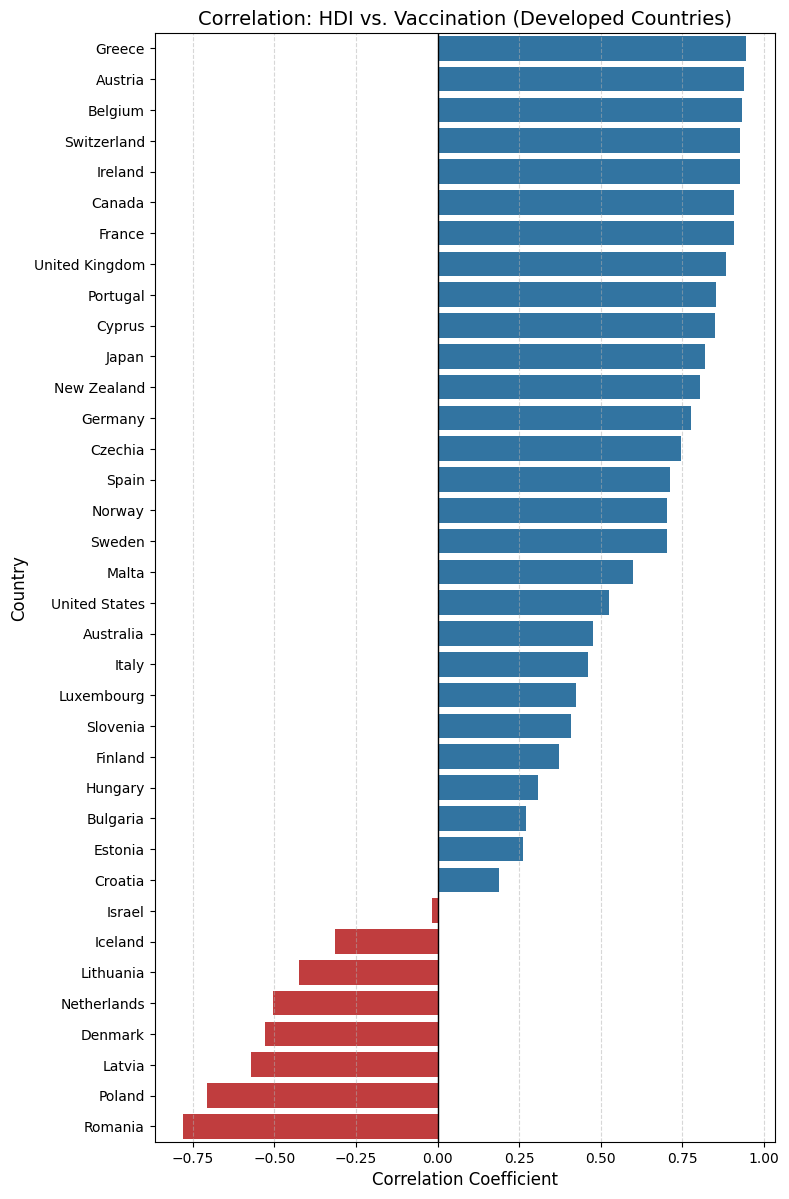

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare the Data
# Your 'stats' variable is likely a Series with a MultiIndex. 
# We convert it to a clean DataFrame and sort it.
corr_df = stats.reset_index()

# Depending on your pandas version, the columns might need renaming.
# Assuming column 0 is 'Country' and the values are 'Correlation'
corr_df.columns = ['Country', 'Variable', 'Correlation'] # 'Variable' is the 'hdi' level we don't need
corr_df = corr_df[['Country', 'Correlation']].sort_values('Correlation', ascending=False)

# 2. Plot
plt.figure(figsize=(8, len(corr_df) * 0.4))  # Auto-adjust height based on N countries

# Color bars by positive/negative value
colors = ['#1f77b4' if x > 0 else '#d62728' for x in corr_df['Correlation']]

sns.barplot(
    data=corr_df, 
    x='Correlation', 
    y='Country', 
    palette=colors  # Blue for positive, Red for negative
)

plt.title('Correlation: HDI vs. Vaccination (Developed Countries)', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.axvline(0, color='black', linewidth=1) # Add a vertical line at 0 for reference
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

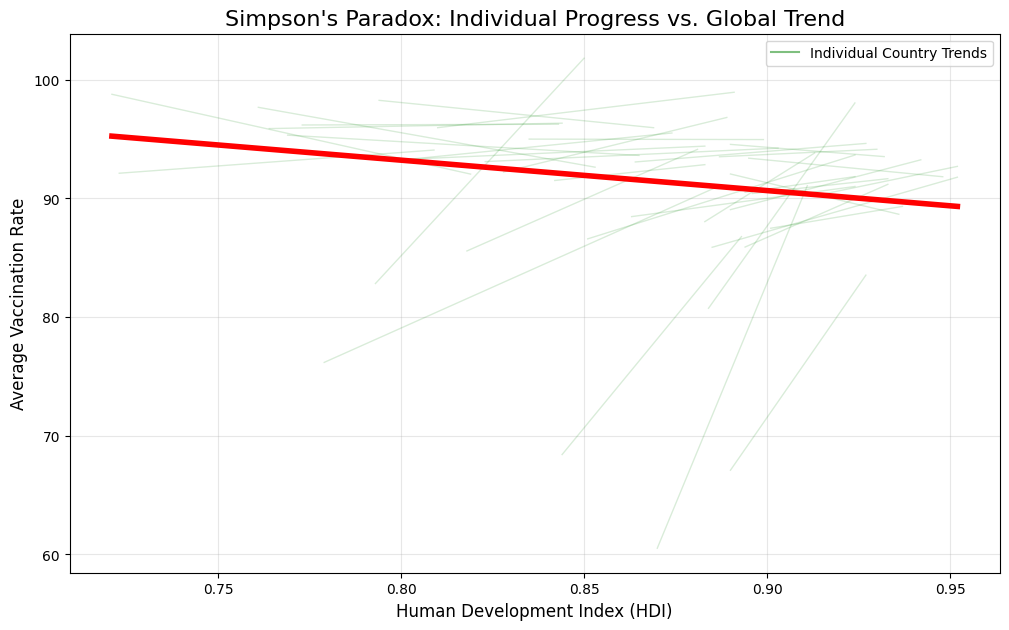

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter Data
dev_df = combined_df[combined_df["Status"] == "Developed"].copy()

plt.figure(figsize=(12, 7))

# 2. Plot INDIVIDUAL Country Trends (The "Spaghetti")
# We loop through countries and plot faint lines for each
# This shows the "Positive" trend you saw in the bar chart
for country in dev_df['Country'].unique():
    subset = dev_df[dev_df['Country'] == country]
    # Only plot if we have enough data points
    if len(subset) > 5:
        sns.regplot(
            x=subset['hdi'], 
            y=subset['avg_vaccination'], 
            ci=None, 
            scatter=False,    # No dots, just lines
            line_kws={'alpha': 0.15, 'color': 'green', 'linewidth': 1} # Faint Green
        )

# 3. Plot the GLOBAL Trend (The "Paradox")
# This pools all data together. This is the "Negative" number you got earlier.
sns.regplot(
    data=dev_df, 
    x='hdi', 
    y='avg_vaccination', 
    scatter=False, 
    ci=None,
    line_kws={'color': 'red', 'linewidth': 4, 'label': 'Global Trend (All Data)'}
)

# Dummy line for legend to represent individual countries
plt.plot([], [], color='green', alpha=0.5, label='Individual Country Trends')

plt.title("Simpson's Paradox: Individual Progress vs. Global Trend", fontsize=16)
plt.xlabel("Human Development Index (HDI)", fontsize=12)
plt.ylabel("Average Vaccination Rate", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

C:\Users\Shir\AppData\Local\Temp\ipykernel_37560\522823371.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')


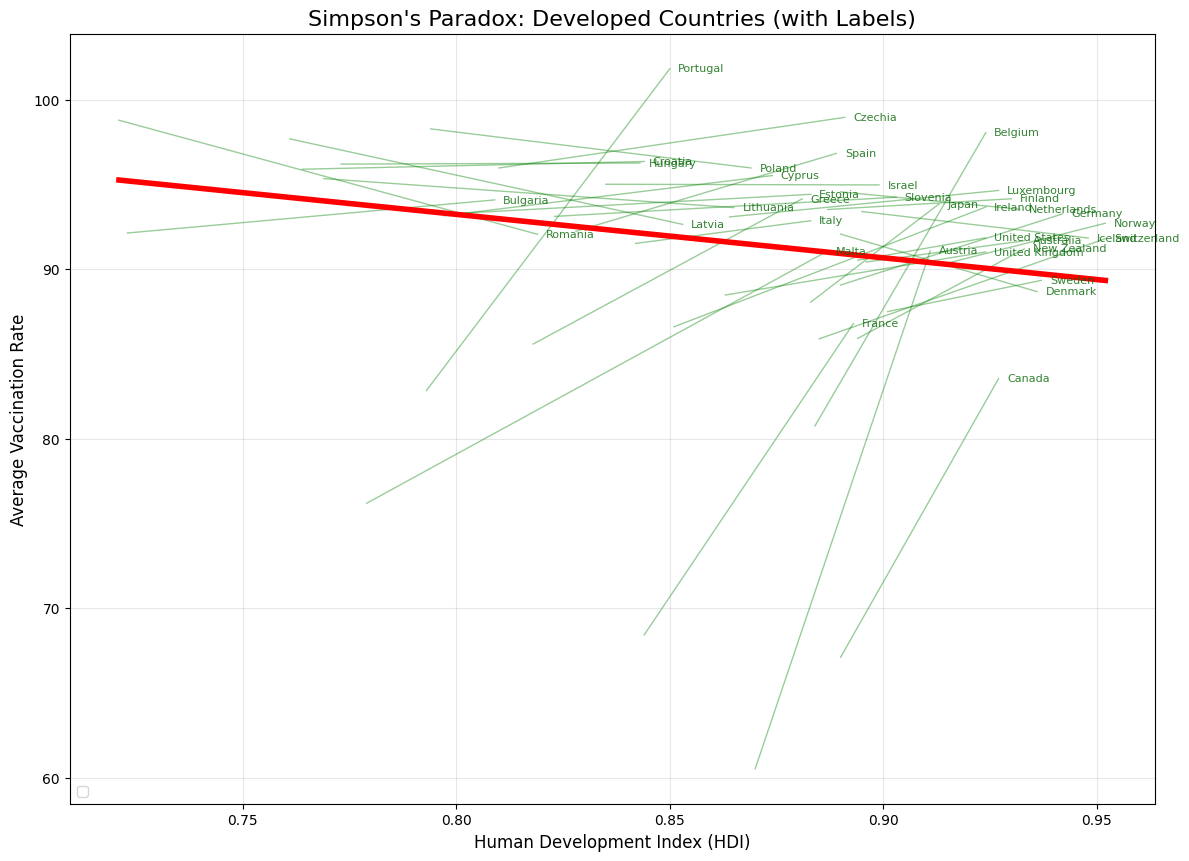

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Needed for calculating label position

# Assumes you still have 'combined_df' loaded
dev_df = combined_df[combined_df["Status"] == "Developed"].copy()

plt.figure(figsize=(14, 10))  # Made the plot larger to accommodate names

# 1. Plot INDIVIDUAL Country Trends with Labels
for country in dev_df['Country'].unique():
    subset = dev_df[dev_df['Country'] == country]
    
    # Only plot if we have enough data points (e.g., > 5 years)
    if len(subset) > 5:
        # Plot the faint green line
        sns.regplot(
            data=subset,
            x='hdi', 
            y='avg_vaccination', 
            ci=None, 
            scatter=False, 
            line_kws={'alpha': 0.4, 'color': 'green', 'linewidth': 1} 
        )
        
        # --- LOGIC TO ADD LABELS ---
        # We fit a quick linear model (y = mx + b) to find where the line ends
        # so we can place the text exactly at the end of the regression line.
        if subset['hdi'].nunique() > 1:
            m, b = np.polyfit(subset['hdi'], subset['avg_vaccination'], 1)
            
            # Get the right-most x-value (highest HDI) for this country
            x_pos = subset['hdi'].max()
            # Calculate the corresponding y-value on the regression line
            y_pos = m * x_pos + b
            
            # Add the text label
            plt.text(
                x_pos + 0.002,  # Shift slightly right for spacing
                y_pos, 
                country, 
                color='darkgreen', 
                fontsize=8, 
                alpha=0.8,
                verticalalignment='center'
            )

# 2. Plot the GLOBAL Trend (The "Paradox")
sns.regplot(
    data=dev_df, 
    x='hdi', 
    y='avg_vaccination', 
    scatter=False, 
    ci=None,
    line_kws={'color': 'red', 'linewidth': 4, 'label': 'Global Trend (Negative Correlation)'}
)

plt.title("Simpson's Paradox: Developed Countries (with Labels)", fontsize=16)
plt.xlabel("Human Development Index (HDI)", fontsize=12)
plt.ylabel("Average Vaccination Rate", fontsize=12)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.show()

In [22]:
combined_df.loc[combined_df["Country"] == "Portugal"]

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy,Status,avg_vaccination,log_GDP,country,year,hdi
264,Portugal,European Union,2013,3.0,3.7,78.8295,9.52,98,96,25.7,...,8.6,1,0,80.7,Developed,97.50,9.830110,Portugal,2013,0.842
291,Portugal,European Union,2007,3.3,4.2,91.6555,11.54,97,95,25.8,...,7.7,1,0,78.3,Developed,96.25,9.901035,Portugal,2007,0.822
629,Portugal,European Union,2014,3.0,3.6,76.9805,10.20,98,96,25.7,...,8.9,1,0,81.1,Developed,97.50,9.843366,Portugal,2014,0.847
748,Portugal,European Union,2015,3.0,3.6,73.2830,10.34,98,95,25.7,...,9.1,1,0,81.1,Developed,97.25,9.865266,Portugal,2015,0.850
794,Portugal,European Union,2011,3.0,3.7,83.8420,10.86,97,96,25.8,...,8.3,1,0,80.5,Developed,96.75,9.871223,Portugal,2011,0.836
809,Portugal,European Union,2004,3.9,5.0,98.0330,12.26,94,79,25.7,...,7.4,1,0,77.7,Developed,90.75,9.857967,Portugal,2004,0.811
1136,Portugal,European Union,2002,4.7,6.1,106.0975,12.50,82,64,25.6,...,7.0,1,0,77.1,Developed,85.00,9.855767,Portugal,2002,0.800
1229,Portugal,European Union,2008,3.2,4.0,89.2665,11.47,97,95,25.8,...,7.8,1,0,78.5,Developed,96.50,9.902787,Portugal,2008,0.825
1433,Portugal,European Union,2001,5.1,6.6,108.3190,12.63,70,56,25.6,...,6.9,1,0,76.8,Developed,79.75,9.853562,Portugal,2001,0.797
1549,Portugal,European Union,2012,3.0,3.7,80.7525,9.76,98,96,25.8,...,8.5,1,0,80.4,Developed,97.50,9.833869,Portugal,2012,0.837


In [ ]:
import pandas as pd

# 1. Load your datasets
df_dtp = pd.read_csv("DTP_coverage.xlsx", encoding='latin1')
df_measles = pd.read_csv("Measles_coverage.xlsx", encoding='latin1')
df_polio = pd.read_csv("Polio_coverage.xlsx", encoding='latin1')
df_hepatitis = pd.read_csv("HepatitisB_coverage.xlsx", encoding='latin1')
df_hdi = pd.read_csv("hdr_general.csv", encoding='latin1') 

# Clean column names
df_hdi.columns = df_hdi.columns.str.strip()
df_dtp.columns = df_dtp.columns.str.strip()
df_measles.columns = df_measles.columns.str.strip()
df_polio.columns = df_polio.columns.str.strip() 
df_hepatitis.columns = df_hepatitis.columns.str.strip()

# Make sure the key columns are numeric
df_hdi["year"] = pd.to_numeric(df_hdi["year"], errors="coerce")
df_hdi["hdi"] = pd.to_numeric(df_hdi["hdi"], errors="coerce")

# Keep only rows where we can plot
df_hdi_plot = df_hdi.dropna(subset=["year", "hdi"]).copy()
df_hdi_plot["year"] = df_hdi_plot["year"].astype(int)

df_hdi_plot = df_hdi_plot[['country', 'year', 'hdi']]

# 2. Perform the Join
# 'how' options:
#   'inner': Only keep rows that exist in BOTH files (intersection).
#   'left' : Keep everything in df_main, add data from df_other where it matches.
combined_df = pd.merge(
    df, 
    df_hdi_plot, 
    left_on=['Country', 'Year'], 
    right_on=['country', 'year'],
    how='inner'
)

FileNotFoundError: [Errno 2] No such file or directory: 'DTP_'

In [2]:
import pandas as pd

# 1. SETUP: List your files and the vaccine names they represent
# Assuming the files are in the current directory or you provide the path
file_map = {
    'DTP3.csv': 'DTP3',
    'HepB3.csv': 'HepB3',
    'MCV1.csv': 'MCV1',
    'Pol3.csv': 'Pol3',
}

# Variable to hold the final merged dataframe
final_df = None

# 2. PROCESS EACH FILE
for filename, vacc_name in file_map.items():
    # Load the data
    df = pd.read_csv(filename)

    # Clean whitespace in column names just in case
    df.columns = df.columns.str.strip()
    
    # 3. MELT (Unpivot) THE TABLE
    # Turns columns "2000", "2001"... into a single "Year" column
    df_melted = df.melt(
        id_vars=['Country'], 
        var_name='Year', 
        value_name=vacc_name
    )
    
    # Ensure Year is a number (it might be read as a string)
    df_melted['Year'] = pd.to_numeric(df_melted['Year'], errors='coerce')
    
    # 4. MERGE
    if final_df is None:
        final_df = df_melted
    else:
        # Outer join ensures we don't lose data if a country/year is missing in one file
        final_df = pd.merge(final_df, df_melted, on=['Country', 'Year'], how='outer')

# 5. FINAL CLEANUP
# Sort for readability
final_df = final_df.sort_values(['Country', 'Year']).reset_index(drop=True)

# 6. CALCULATE AVERAGE VACCINATION
# We select only the columns that are vaccination names
vaccine_cols = list(file_map.values())
final_df['average_vaccination'] = final_df[vaccine_cols].mean(axis=1)

# Check the result
print(final_df.head())

# Optional: Save to CSV
# final_df.to_csv("global_vaccination_data.csv", index=False)

       Country  Year  DTP3  HepB3  MCV1  Pol3  average_vaccination
0  Afghanistan  2000  24.0    NaN  27.0  24.0            25.000000
1  Afghanistan  2001  33.0    NaN  37.0  35.0            35.000000
2  Afghanistan  2002  36.0    NaN  35.0  36.0            35.666667
3  Afghanistan  2003  41.0    NaN  39.0  41.0            40.333333
4  Afghanistan  2004  50.0    NaN  48.0  50.0            49.333333


In [4]:
# 1. Load your datasets
df_hdi = pd.read_csv("hdr_general.csv", encoding='latin1')
# Clean column names
df_hdi.columns = df_hdi.columns.str.strip()

# Make sure the key columns are numeric
df_hdi["year"] = pd.to_numeric(df_hdi["year"], errors="coerce")
df_hdi["hdi"] = pd.to_numeric(df_hdi["hdi"], errors="coerce")

# Keep only rows where we can plot
df_hdi_plot = df_hdi.dropna(subset=["year", "hdi"]).copy()
df_hdi_plot["year"] = df_hdi_plot["year"].astype(int)

df_hdi_plot = df_hdi_plot[['country', 'year', 'hdi']]

# 2. Perform the Join
# 'how' options:
#   'inner': Only keep rows that exist in BOTH files (intersection).
#   'left' : Keep everything in df_main, add data from df_other where it matches.
combined_df = pd.merge(
    final_df, 
    df_hdi_plot, 
    left_on=['Country', 'Year'], 
    right_on=['country', 'year'],
    how='inner'
)

# 3. Check the result
print(combined_df.head())
print(len(combined_df))
print(len(final_df))

       Country  Year  DTP3  HepB3  MCV1  Pol3  average_vaccination  \
0  Afghanistan  2000  24.0    NaN  27.0  24.0            25.000000   
1  Afghanistan  2001  33.0    NaN  37.0  35.0            35.000000   
2  Afghanistan  2002  36.0    NaN  35.0  36.0            35.666667   
3  Afghanistan  2003  41.0    NaN  39.0  41.0            40.333333   
4  Afghanistan  2004  50.0    NaN  48.0  50.0            49.333333   

       country  year    hdi  
0  Afghanistan  2000  0.340  
1  Afghanistan  2001  0.344  
2  Afghanistan  2002  0.368  
3  Afghanistan  2003  0.379  
4  Afghanistan  2004  0.395  
3919
4290


In [18]:
df_status = df[['Country', 'Status']].drop_duplicates()

combined_df_with_status = pd.merge(
    combined_df, 
    df_status, 
    left_on=['Country'], 
    right_on=['Country'],
    how='inner'
)

combined_df_with_status = combined_df_with_status[['Country', 'Year', 'average_vaccination', 'hdi', 'Status']]

print(combined_df_with_status.head())



       Country  Year  average_vaccination    hdi      Status
0  Afghanistan  2000            25.000000  0.340  Developing
1  Afghanistan  2001            35.000000  0.344  Developing
2  Afghanistan  2002            35.666667  0.368  Developing
3  Afghanistan  2003            40.333333  0.379  Developing
4  Afghanistan  2004            49.333333  0.395  Developing


C:\Users\Shir\AppData\Local\Temp\ipykernel_11996\673884324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_from_2016['Country'] = df_from_2016['Country'].replace("United States of America", "United States")


Correlation (HDI vs Vaccination):
Status         
Developed   hdi    0.005125
Developing  hdi    0.471553
Name: average_vaccination, dtype: float64


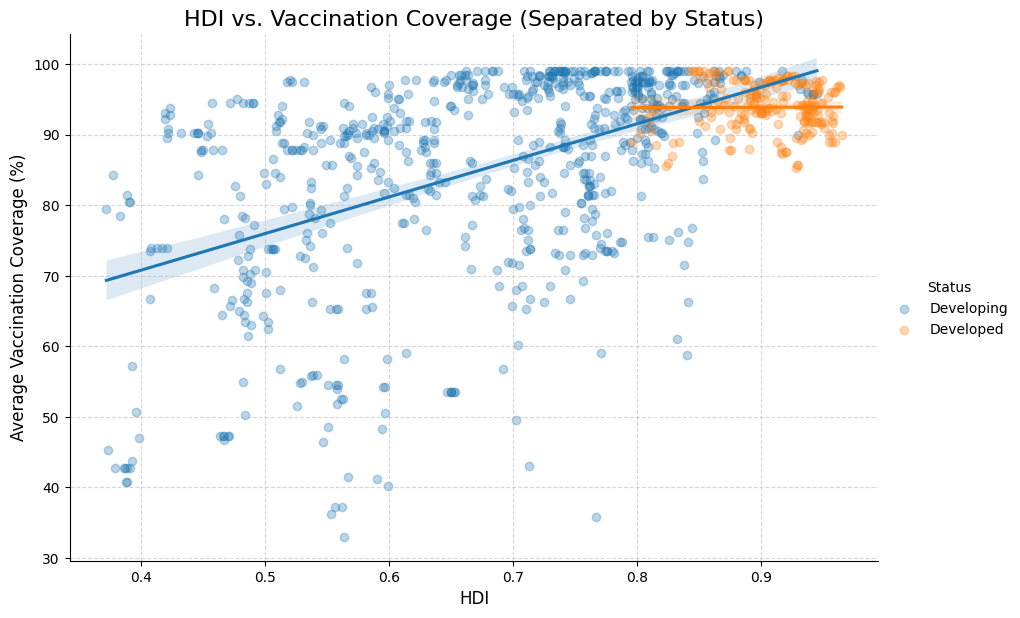

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_from_2016 = combined_df_with_status.loc[combined_df_with_status['Year'] >= 2016]
df_from_2016['Country'] = df_from_2016['Country'].replace("United States of America", "United States")

# 3. Calculate Correlations for each group
stats = df_from_2016.groupby('Status')[['hdi', 'average_vaccination']].corr().iloc[0::2, -1]
print("Correlation (HDI vs Vaccination):")
print(stats)

# 4. Plot
# lmplot draws scatter plots with regression lines for each 'hue' category
sns.lmplot(
    data=df_from_2016, 
    x='hdi', 
    y='average_vaccination', 
    hue='Status', 
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)

plt.title('HDI vs. Vaccination Coverage (Separated by Status)', fontsize=16)
plt.xlabel('HDI', fontsize=12)
plt.ylabel('Average Vaccination Coverage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Correlation (HDI vs Vaccination):
Country         
Australia    hdi   -0.045023
Austria      hdi   -0.666477
Belgium      hdi   -0.095929
Bulgaria     hdi    0.842593
Canada       hdi    0.542863
Croatia      hdi    0.125388
Cyprus       hdi   -0.717598
Czechia      hdi    0.190079
Denmark      hdi    0.252911
Estonia      hdi   -0.711713
Finland      hdi   -0.357592
France       hdi    0.727607
Germany      hdi   -0.233126
Greece       hdi         NaN
Hungary      hdi         NaN
Iceland      hdi    0.416511
Ireland      hdi   -0.874200
Israel       hdi    0.787336
Italy        hdi    0.689672
Japan        hdi   -0.629063
Latvia       hdi    0.599914
Lithuania    hdi   -0.205229
Luxembourg   hdi    0.564076
Malta        hdi    0.479811
Netherlands  hdi   -0.298807
New Zealand  hdi   -0.281963
Norway       hdi    0.820271
Poland       hdi   -0.302305
Portugal     hdi    0.757027
Romania      hdi    0.230680
Slovenia     hdi   -0.289011
Spain        hdi   -0.436898
Sweden       hdi    0

C:\Users\Shir\AppData\Local\Temp\ipykernel_11996\3701018062.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


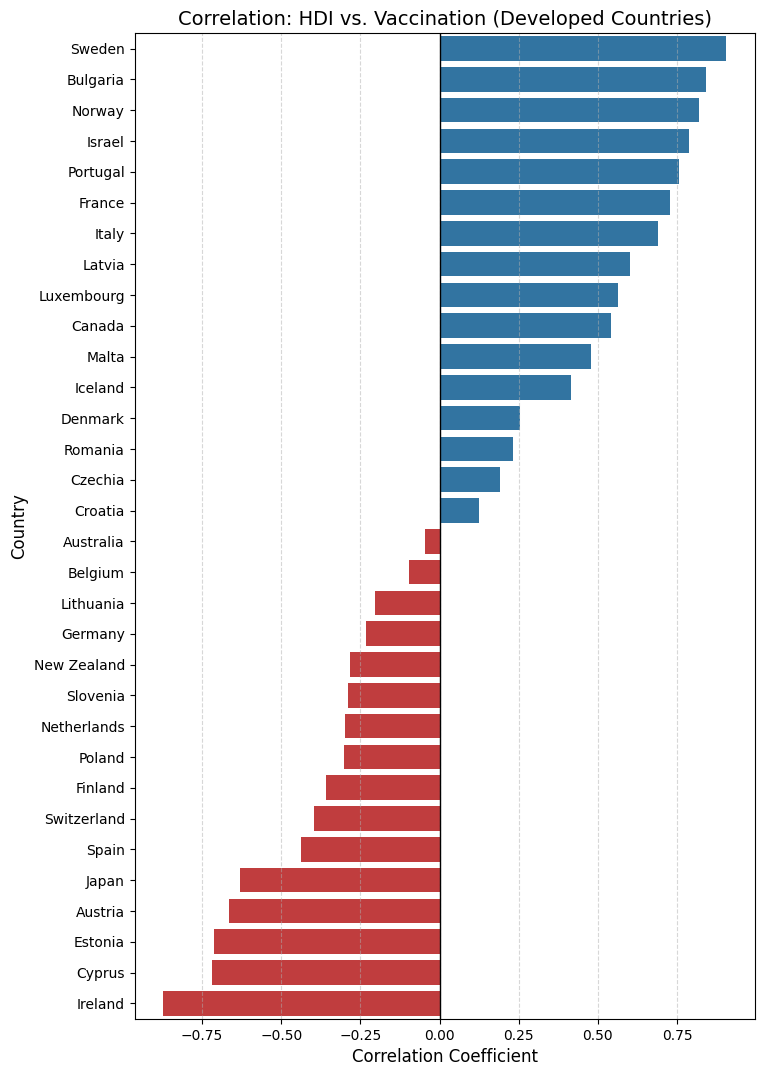

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

stats = df_from_2016.loc[df_from_2016["Status"] == "Developed"].groupby('Country')[['hdi', 'average_vaccination']].corr().iloc[0::2, -1]
print("Correlation (HDI vs Vaccination):")
print(stats)

# 1. Prepare the Data
# Your 'stats' variable is likely a Series with a MultiIndex. 
# We convert it to a clean DataFrame and sort it.
corr_df = stats.reset_index()

# Depending on your pandas version, the columns might need renaming.
# Assuming column 0 is 'Country' and the values are 'Correlation'
corr_df.columns = ['Country', 'Variable', 'Correlation'] # 'Variable' is the 'hdi' level we don't need
corr_df = corr_df[['Country', 'Correlation']].sort_values('Correlation', ascending=False)
corr_df = corr_df.dropna()

# 2. Plot
plt.figure(figsize=(8, len(corr_df) * 0.4))  # Auto-adjust height based on N countries

# Color bars by positive/negative value
colors = ['#1f77b4' if x > 0 else '#d62728' for x in corr_df['Correlation']]

sns.barplot(
    data=corr_df, 
    x='Correlation', 
    y='Country', 
    palette=colors  # Blue for positive, Red for negative
)

plt.title('Correlation: HDI vs. Vaccination (Developed Countries)', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.axvline(0, color='black', linewidth=1) # Add a vertical line at 0 for reference
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()